In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.losses import MeanSquaredError
from keras.models import Model, Sequential
from keras.applications.vgg19 import preprocess_input, VGG19
from keras.layers import concatenate, Activation, Add, AveragePooling2D, BatchNormalization, Conv2D, Conv2DTranspose, Dense, Flatten, Input,LeakyReLU, MaxPooling2D, Multiply, Reshape, UpSampling2D
from keras.optimizers import Adam, RMSprop

In [2]:
samples = []
gts = []
test_samples = []
test_gts = []

for i in range(1,361):
    sample = cv2.imread("Dataset_Part1/Dataset_Part1/" + str(i) + "/1.jpg")
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
    sample = cv2.resize(sample, (512, 512))
    gt = cv2.imread("Dataset_Part1/Dataset_Part1/Label/" + str(i) + ".jpg")
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
    gt = cv2.resize(gt, (512, 512))

    samples.append(sample)
    gts.append(gt)

for j in range(357,361):
    test_sample = cv2.imread("Dataset_Part1/Dataset_Part1/" + str(j) + "/1.jpg")
    test_sample = cv2.cvtColor(test_sample, cv2.COLOR_BGR2RGB)
    test_sample = cv2.resize(test_sample, (512, 512))
    test_gt = cv2.imread("Dataset_Part1/Dataset_Part1/Label/" + str(j) + ".jpg")
    test_gt = cv2.cvtColor(test_gt, cv2.COLOR_BGR2RGB)
    test_gt = cv2.resize(test_gt, (512, 512))

    test_samples.append(test_sample)
    test_gts.append(test_gt)

for k in range(1,126):
    sample2 = cv2.imread("Dataset_Part2/Dataset_Part2/" + str(k) + "/1.jpg")
    sample2 = cv2.cvtColor(sample2, cv2.COLOR_BGR2RGB)
    sample2 = cv2.resize(sample2, (512, 512))
    gt2 = cv2.imread("Dataset_Part2/Dataset_Part2/Label/" + str(k) + ".jpg")
    gt2 = cv2.cvtColor(gt2, cv2.COLOR_BGR2RGB)
    gt2 = cv2.resize(gt2, (512, 512))

    samples.append(sample2)
    gts.append(gt2)

for l in range(126,230):
    sample2 = cv2.imread("Dataset_Part2/Dataset_Part2/" + str(l) + "/1.jpg")
    sample2 = cv2.cvtColor(sample2, cv2.COLOR_BGR2RGB)
    sample2 = cv2.resize(sample2, (512, 512))
    gt2 = cv2.imread("Dataset_Part2/Dataset_Part2/Label/" + str(l) + ".png")
    gt2 = cv2.cvtColor(gt2, cv2.COLOR_BGR2RGB)
    gt2 = cv2.resize(gt2, (512, 512))

    samples.append(sample2)
    gts.append(gt2)

print(i)
print(j)
print(k)
print(l)

356
360
125
229


In [3]:
samples = np.array(samples)/255
gts = np.array(gts)/255
test_samples = np.array(test_samples)/255
test_gts = np.array(test_gts)/255

print(samples.shape)
print(gts.shape)
print(test_samples.shape)
print(test_gts.shape)

(585, 512, 512, 3)
(585, 512, 512, 3)
(4, 512, 512, 3)
(4, 512, 512, 3)


In [59]:
input_shape=(512,512,3)
epochs = 50
batch_size=15
n_batches = int(samples.shape[0] // batch_size)
optimizer = Adam(1e-4)
# optimizer = Adam(0.0004, 0.5)

In [5]:
def MLP(input):
    inputs = Input(shape=input.shape)
    layer1 = Conv2D(256, kernel_size=3, padding="same")(inputs)
    layer2 = Conv2D(512, kernel_size=3, padding="same")(layer1)

    # mlp = Model(inputs=[inputs], outputs=[layer2])

    return layer2

In [6]:
# channel attention
def Channel_Attention(input):
    inputs = Input(shape=(16,16,512))
    max1 = MaxPooling2D(pool_size=16)(inputs)
    avg1 = AveragePooling2D(pool_size=16)(inputs)
    mlp_max = MLP(max1)
    mlp_avg = MLP(avg1)
    add = Add()([mlp_avg, mlp_max])
    add = Reshape((1,1,512))(add)
    atv = Activation(activation="sigmoid")(add)

    # ca = Model(inputs=[inputs], outputs=[atv])

    return atv

In [ ]:
# spatial attention
def Spatial_Attention():
    

In [7]:
# generator
def Generator():
    inputs = Input(shape=input_shape)
    # inputs = Reshape(input_shape)(inputs)
    conv1 = Conv2D(64, kernel_size=3, strides=2, padding="same")(inputs)
    conv1 = BatchNormalization(momentum=0.8)(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    print("conv1", conv1.shape)

    conv2 = Conv2D(128, kernel_size=3, strides=2, padding="same")(conv1)
    conv2 = BatchNormalization(momentum=0.8)(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    print("conv2", conv2.shape)

    conv3 = Conv2D(256, kernel_size=3, strides=2, padding="same")(conv2)
    conv3 = BatchNormalization(momentum=0.8)(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    print("conv3", conv3.shape)

    conv4 = Conv2D(512, kernel_size=3, strides=2, padding="same")(conv3)
    conv4 = BatchNormalization(momentum=0.8)(conv4)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    print("conv4", conv4.shape)

    conv5 = Conv2D(1024, kernel_size=3, strides=2, padding="same")(conv4)
    conv5 = BatchNormalization(momentum=0.8)(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    print("conv5", conv5.shape)

    # up6 = Conv2D(512, kernel_size=3, strides=2)(UpSampling2D(size=(2,2))(conv5))
    up6 = Conv2DTranspose(512, kernel_size=3, strides=2, padding="same")(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, kernel_size=3, strides=2, padding="same")(merge6)
    conv6 = BatchNormalization(momentum=0.8)(conv6)
    conv6 = LeakyReLU(alpha=0.2)(conv6)
    print("conv6", conv6.shape)

    ca1 = Channel_Attention(conv6)
    print("ca1", ca1.shape)

    mult1 = Multiply()([conv6, ca1])
    print("mult1", mult1.shape)

    # up7 = Conv2D(256, kernel_size=3, strides=2, padding="same")(UpSampling2D(size=(2,2))(conv6))
    up7 = Conv2DTranspose(256, kernel_size=3, strides=2, padding="same")(UpSampling2D(size=(2,2))(mult1))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, kernel_size=3, strides=2, padding="same")(merge7)
    conv7 = BatchNormalization(momentum=0.8)(conv7)
    conv7 = LeakyReLU(alpha=0.2)(conv7)
    print("conv7", conv7.shape)

    # up8 = Conv2D(128, kernel_size=3, strides=2)(UpSampling2D(size=(2,2))(conv7))
    up8 = Conv2DTranspose(128, kernel_size=3, strides=2, padding="same")(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, kernel_size=3, strides=2, padding="same")(merge8)
    conv8 = BatchNormalization(momentum=0.8)(conv8)
    conv8 = LeakyReLU(alpha=0.2)(conv8)
    print("conv8", conv8.shape)

    # up9 = Conv2D(64, kernel_size=3, strides=2)(UpSampling2D(size=(2,2))(conv8))
    up9 = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, kernel_size=3, strides=2, padding="same")(merge9)
    conv9 = BatchNormalization(momentum=0.8)(conv9)
    conv9 = LeakyReLU(alpha=0.2)(conv9)
    print("conv9", conv9.shape)

    conv10 = Conv2DTranspose(3, kernel_size=3, strides=2, activation="sigmoid", padding="same")(UpSampling2D(size=(2,2))(conv9))
    print("conv10", conv10.shape)

    generator = Model(inputs=[inputs], outputs=[conv10])

    generator.summary()

    return generator

In [57]:
# generator
def Generator():
    inputs = Input(shape=input_shape)
    # inputs = Reshape(input_shape)(inputs)
    conv1 = Conv2D(64, kernel_size=3, strides=2, padding="same")(inputs)
    conv1 = BatchNormalization(momentum=0.8)(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    print("conv1", conv1.shape)

    conv2 = Conv2D(128, kernel_size=3, strides=2, padding="same")(conv1)
    conv2 = BatchNormalization(momentum=0.8)(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    print("conv2", conv2.shape)

    conv3 = Conv2D(256, kernel_size=3, strides=2, padding="same")(conv2)
    conv3 = BatchNormalization(momentum=0.8)(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    print("conv3", conv3.shape)

    conv4 = Conv2D(512, kernel_size=3, strides=2, padding="same")(conv3)
    conv4 = BatchNormalization(momentum=0.8)(conv4)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    print("conv4", conv4.shape)

    conv5 = Conv2D(1024, kernel_size=3, strides=2, padding="same")(conv4)
    conv5 = BatchNormalization(momentum=0.8)(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    print("conv5", conv5.shape)

    # up6 = Conv2D(512, kernel_size=3, strides=2)(UpSampling2D(size=(2,2))(conv5))
    up6 = Conv2DTranspose(512, kernel_size=3, strides=2, padding="same")(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, kernel_size=3, strides=2, padding="same")(merge6)
    conv6 = BatchNormalization(momentum=0.8)(conv6)
    conv6 = LeakyReLU(alpha=0.2)(conv6)
    print("conv6", conv6.shape)

    max1 = MaxPooling2D(pool_size=16)(conv6)
    avg1 = AveragePooling2D(pool_size=16)(conv6)
    mlp_max_layer1 = Conv2D(256, kernel_size=3, padding="same")(max1)
    mlp_max_layer2 = Conv2D(512, kernel_size=3, padding="same")(mlp_max_layer1)
    mlp_avg_layer1 = Conv2D(256, kernel_size=3, padding="same")(avg1)
    mlp_avg_layer2 = Conv2D(512, kernel_size=3, padding="same")(mlp_avg_layer1)
    add = Add()([mlp_max_layer2, mlp_avg_layer2])
    add = Reshape((1,1,512))(add)
    atv = Activation(activation="sigmoid")(add)
    print("ca1", atv.shape)

    # ca1 = Channel_Attention(conv6)
    # print("ca1", ca1.shape)

    mult1 = Multiply()([conv6, atv])
    print("mult1", mult1.shape)

    f = Conv2D(256, kernel_size=1, strides=1, padding="valid")(mult1)
    f = Reshape((256,256))(f)
    print("f", f.shape)
    g = Conv2D(256, kernel_size=1, strides=1, padding="valid")(mult1)
    g = Reshape((256,256))(g)
    print("g", g.shape)
    h = Conv2D(512, kernel_size=1, strides=1, padding="valid")(mult1)
    h = Reshape((256,512))(h)
    print("h", h.shape)

    s = Multiply()([g, f])
    print("s", s.shape)
    beta = Activation(activation="softmax")(s)
    print("beta", beta.shape)
    x = keras.backend.variable(value=beta)
    y = keras.backend.variable(value=h)
    o = keras.backend.dot(x, y)
    keras.eval(o)
    print("o", o.shape)

    o = Reshape((16,16,512))(o)
    sum = o + mult1
    print("sum", sum.shape)

    # up7 = Conv2D(256, kernel_size=3, strides=2, padding="same")(UpSampling2D(size=(2,2))(conv6))
    up7 = Conv2DTranspose(256, kernel_size=3, strides=2, padding="same")(UpSampling2D(size=(2,2))(sum))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, kernel_size=3, strides=2, padding="same")(merge7)
    conv7 = BatchNormalization(momentum=0.8)(conv7)
    conv7 = LeakyReLU(alpha=0.2)(conv7)
    print("conv7", conv7.shape)

    # up8 = Conv2D(128, kernel_size=3, strides=2)(UpSampling2D(size=(2,2))(conv7))
    up8 = Conv2DTranspose(128, kernel_size=3, strides=2, padding="same")(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, kernel_size=3, strides=2, padding="same")(merge8)
    conv8 = BatchNormalization(momentum=0.8)(conv8)
    conv8 = LeakyReLU(alpha=0.2)(conv8)
    print("conv8", conv8.shape)

    # up9 = Conv2D(64, kernel_size=3, strides=2)(UpSampling2D(size=(2,2))(conv8))
    up9 = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, kernel_size=3, strides=2, padding="same")(merge9)
    conv9 = BatchNormalization(momentum=0.8)(conv9)
    conv9 = LeakyReLU(alpha=0.2)(conv9)
    print("conv9", conv9.shape)

    conv10 = Conv2DTranspose(3, kernel_size=3, strides=2, activation="sigmoid", padding="same")(UpSampling2D(size=(2,2))(conv9))
    print("conv10", conv10.shape)

    generator = Model(inputs=[inputs], outputs=[conv10])

    generator.summary()

    return generator

In [60]:
# generator
def Generator():
    inputs = Input(shape=input_shape)
    # inputs = Reshape(input_shape)(inputs)
    conv1 = Conv2D(64, kernel_size=3, strides=2, padding="same")(inputs)
    conv1 = BatchNormalization(momentum=0.8)(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    print("conv1", conv1.shape)

    conv2 = Conv2D(128, kernel_size=3, strides=2, padding="same")(conv1)
    conv2 = BatchNormalization(momentum=0.8)(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    print("conv2", conv2.shape)

    conv3 = Conv2D(256, kernel_size=3, strides=2, padding="same")(conv2)
    conv3 = BatchNormalization(momentum=0.8)(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    print("conv3", conv3.shape)

    conv4 = Conv2D(512, kernel_size=3, strides=2, padding="same")(conv3)
    conv4 = BatchNormalization(momentum=0.8)(conv4)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    print("conv4", conv4.shape)

    conv5 = Conv2D(1024, kernel_size=3, strides=2, padding="same")(conv4)
    conv5 = BatchNormalization(momentum=0.8)(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    print("conv5", conv5.shape)

    # up6 = Conv2D(512, kernel_size=3, strides=2)(UpSampling2D(size=(2,2))(conv5))
    up6 = Conv2DTranspose(512, kernel_size=3, strides=2, padding="same")(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, kernel_size=3, strides=2, padding="same")(merge6)
    conv6 = BatchNormalization(momentum=0.8)(conv6)
    conv6 = LeakyReLU(alpha=0.2)(conv6)
    print("conv6", conv6.shape)

    max1 = MaxPooling2D(pool_size=16)(conv6)
    avg1 = AveragePooling2D(pool_size=16)(conv6)
    mlp_max_layer1 = Conv2D(256, kernel_size=3, padding="same")(max1)
    mlp_max_layer2 = Conv2D(512, kernel_size=3, padding="same")(mlp_max_layer1)
    mlp_avg_layer1 = Conv2D(256, kernel_size=3, padding="same")(avg1)
    mlp_avg_layer2 = Conv2D(512, kernel_size=3, padding="same")(mlp_avg_layer1)
    add = Add()([mlp_max_layer2, mlp_avg_layer2])
    add = Reshape((1,1,512))(add)
    atv = Activation(activation="sigmoid")(add)
    print("ca1", atv.shape)

    mult1 = Multiply()([conv6, atv])
    print("mult1", mult1.shape)

    # up7 = Conv2D(256, kernel_size=3, strides=2, padding="same")(UpSampling2D(size=(2,2))(conv6))
    up7 = Conv2DTranspose(256, kernel_size=3, strides=2, padding="same")(UpSampling2D(size=(2,2))(mult1))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, kernel_size=3, strides=2, padding="same")(merge7)
    conv7 = BatchNormalization(momentum=0.8)(conv7)
    conv7 = LeakyReLU(alpha=0.2)(conv7)
    print("conv7", conv7.shape)

    # up8 = Conv2D(128, kernel_size=3, strides=2)(UpSampling2D(size=(2,2))(conv7))
    up8 = Conv2DTranspose(128, kernel_size=3, strides=2, padding="same")(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, kernel_size=3, strides=2, padding="same")(merge8)
    conv8 = BatchNormalization(momentum=0.8)(conv8)
    conv8 = LeakyReLU(alpha=0.2)(conv8)
    print("conv8", conv8.shape)

    # up9 = Conv2D(64, kernel_size=3, strides=2)(UpSampling2D(size=(2,2))(conv8))
    up9 = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, kernel_size=3, strides=2, padding="same")(merge9)
    conv9 = BatchNormalization(momentum=0.8)(conv9)
    conv9 = LeakyReLU(alpha=0.2)(conv9)
    print("conv9", conv9.shape)

    conv10 = Conv2DTranspose(3, kernel_size=3, strides=2, activation="sigmoid", padding="same")(UpSampling2D(size=(2,2))(conv9))
    print("conv10", conv10.shape)

    generator = Model(inputs=[inputs], outputs=[conv10])

    generator.summary()

    return generator

In [61]:
# discriminator
def Discriminator():
    discriminator = Sequential(
        [
            Conv2D(64, kernel_size=5, strides=2, input_shape=input_shape),
            BatchNormalization(momentum=0.8),
            LeakyReLU(alpha=0.2),
            Conv2D(128, kernel_size=5, strides=2),
            BatchNormalization(momentum=0.8),
            LeakyReLU(alpha=0.2),
            Conv2D(128, kernel_size=3, strides=2),
            BatchNormalization(momentum=0.8),
            LeakyReLU(alpha=0.2),
            Conv2D(256, kernel_size=3, strides=2),
            BatchNormalization(momentum=0.8),
            LeakyReLU(alpha=0.2),
            Conv2D(1, kernel_size=3, strides=1),
            Flatten(),
            Dense(1024, activation="relu"),
            Dense(1, activation="sigmoid")
        ]
    )

    # discriminator.summary()

    # discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return discriminator

In [62]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [63]:
generator = Generator()
discriminator = Discriminator()

conv1 (None, 256, 256, 64)
conv2 (None, 128, 128, 128)
conv3 (None, 64, 64, 256)
conv4 (None, 32, 32, 512)
conv5 (None, 16, 16, 1024)
conv6 (None, 16, 16, 512)
ca1 (None, 1, 1, 512)
mult1 (None, 16, 16, 512)
conv7 (None, 32, 32, 256)
conv8 (None, 64, 64, 128)
conv9 (None, 128, 128, 64)
conv10 (None, 512, 512, 3)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_327 (Conv2D)            (None, 256, 256, 64  1792        ['input_29[0][0]']               
                                )                                          

In [64]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [65]:
def discriminator_loss(hdr_output, ldr_output):
    real_loss = cross_entropy(tf.ones_like(hdr_output), hdr_output)
    fake_loss = cross_entropy(tf.zeros_like(ldr_output), ldr_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [66]:
def generator_loss(ldr_output):
    return cross_entropy(tf.ones_like(ldr_output), ldr_output)

In [67]:
def content_loss(hdr_output, ldr_output):
    r_loss = tf.reduce_mean(tf.reduce_sum(tf.square(hdr_output[:,:,:,0] - ldr_output[:,:,:,0]), [1,2]) / (batch_size * batch_size))
    g_loss = tf.reduce_mean(tf.reduce_sum(tf.square(hdr_output[:,:,:,1] - ldr_output[:,:,:,1]), [1,2]) / (batch_size * batch_size))
    b_loss = tf.reduce_mean(tf.reduce_sum(tf.square(hdr_output[:,:,:,2] - ldr_output[:,:,:,2]), [1,2]) / (batch_size * batch_size))
    mse_loss = (r_loss + g_loss + b_loss) /3
    return mse_loss

In [68]:
for epoch in range(epochs):
    idx = np.arange(samples.shape[0])
    np.random.shuffle(idx)
    idx = np.reshape(idx, (n_batches, batch_size))

    for batch in range(n_batches):
        ldr = samples[idx[batch]]
        hdr = gts[idx[batch]]
    
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(ldr, training=True)

            hdr_output = discriminator(hdr, training=True)
            ldr_output = discriminator(generated_images, training=True)

            # ldr_features = preprocess_input(ldr)
            # hdr_features = preprocess_input(hdr)
            con_loss = content_loss(hdr, generated_images)
            gen_loss = generator_loss(ldr_output)
            perc_loss = con_loss + 0.001 * gen_loss
            disc_loss = discriminator_loss(hdr_output, ldr_output)

        gradients_of_generator = gen_tape.gradient(perc_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        print("epoch ", epoch+1, ", batch", batch+1, " - GEN: ", gen_loss, "DISC: ", disc_loss)

epoch  1 , batch 1  - GEN:  tf.Tensor(1.0386056, shape=(), dtype=float32) DISC:  tf.Tensor(1.7010244, shape=(), dtype=float32)
epoch  1 , batch 2  - GEN:  tf.Tensor(0.9174635, shape=(), dtype=float32) DISC:  tf.Tensor(1.659438, shape=(), dtype=float32)
epoch  1 , batch 3  - GEN:  tf.Tensor(1.1282378, shape=(), dtype=float32) DISC:  tf.Tensor(1.2963905, shape=(), dtype=float32)
epoch  1 , batch 4  - GEN:  tf.Tensor(0.9295409, shape=(), dtype=float32) DISC:  tf.Tensor(1.3903356, shape=(), dtype=float32)
epoch  1 , batch 5  - GEN:  tf.Tensor(1.013526, shape=(), dtype=float32) DISC:  tf.Tensor(1.3652272, shape=(), dtype=float32)
epoch  1 , batch 6  - GEN:  tf.Tensor(1.0277306, shape=(), dtype=float32) DISC:  tf.Tensor(1.2883444, shape=(), dtype=float32)
epoch  1 , batch 7  - GEN:  tf.Tensor(1.243955, shape=(), dtype=float32) DISC:  tf.Tensor(1.2796441, shape=(), dtype=float32)
epoch  1 , batch 8  - GEN:  tf.Tensor(1.6009996, shape=(), dtype=float32) DISC:  tf.Tensor(1.332906, shape=(), dty

In [69]:
gen_imgs = generator.predict(test_samples)
# gen_imgs = adv.layers[0].predict(ldr)

1/1 [==============================] - 1s 929ms/step


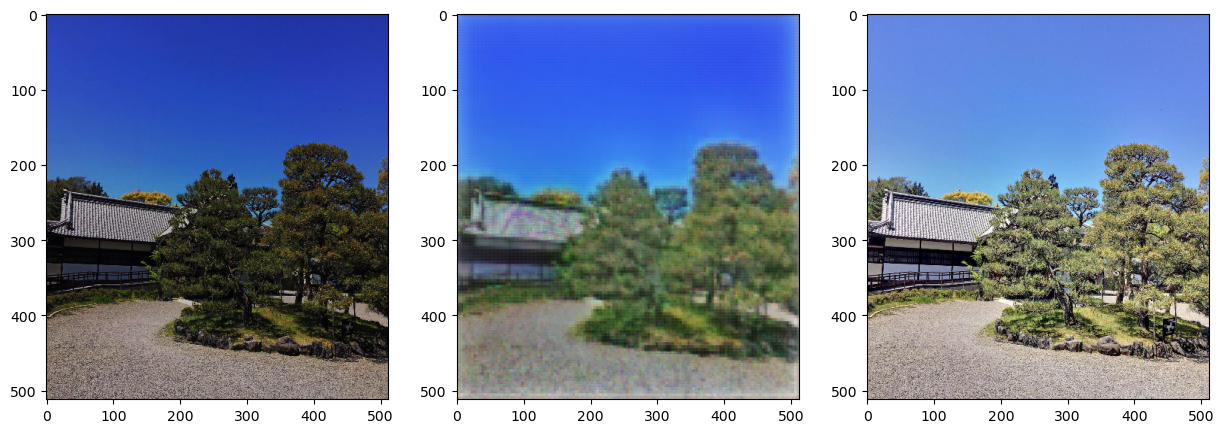

In [22]:
f, ax= plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(test_samples[0], aspect="auto")
ax[1].imshow(gen_imgs[0], aspect="auto")
ax[2].imshow(test_gts[0], aspect="auto")
plt.show()

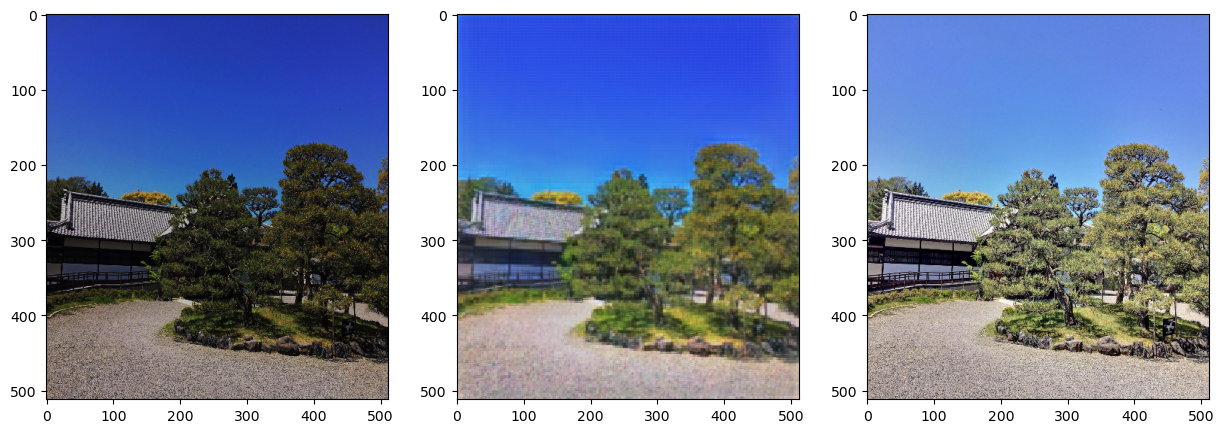

In [70]:
f, ax= plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(test_samples[0], aspect="auto")
ax[1].imshow(gen_imgs[0], aspect="auto")
ax[2].imshow(test_gts[0], aspect="auto")
plt.show()

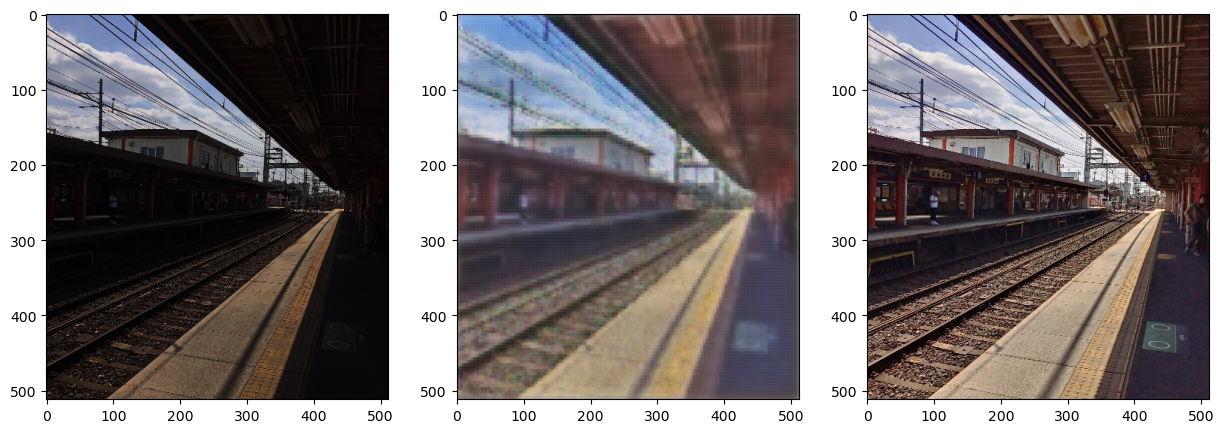

In [23]:
f, ax= plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(test_samples[1], aspect="auto")
ax[1].imshow(gen_imgs[1], aspect="auto")
ax[2].imshow(test_gts[1], aspect="auto")
plt.show()

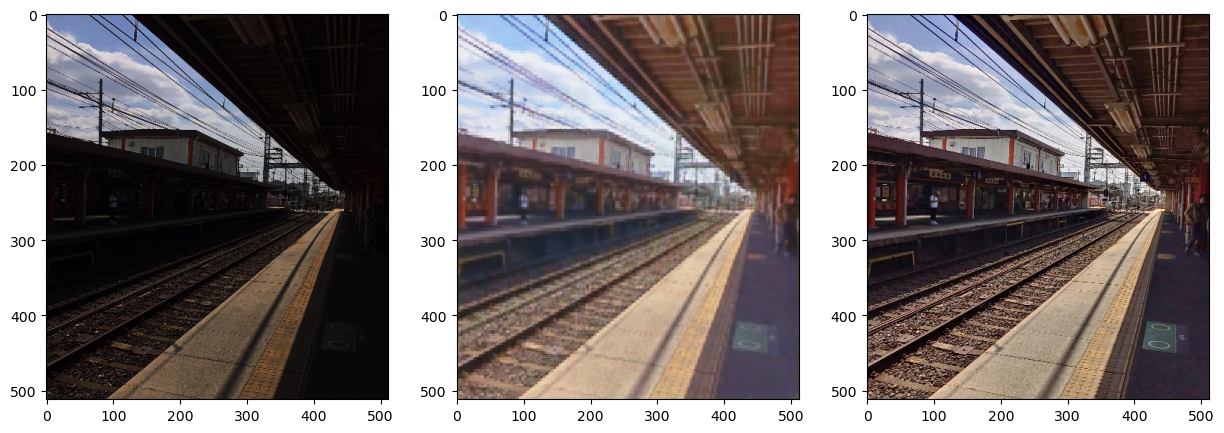

In [71]:
f, ax= plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(test_samples[1], aspect="auto")
ax[1].imshow(gen_imgs[1], aspect="auto")
ax[2].imshow(test_gts[1], aspect="auto")
plt.show()

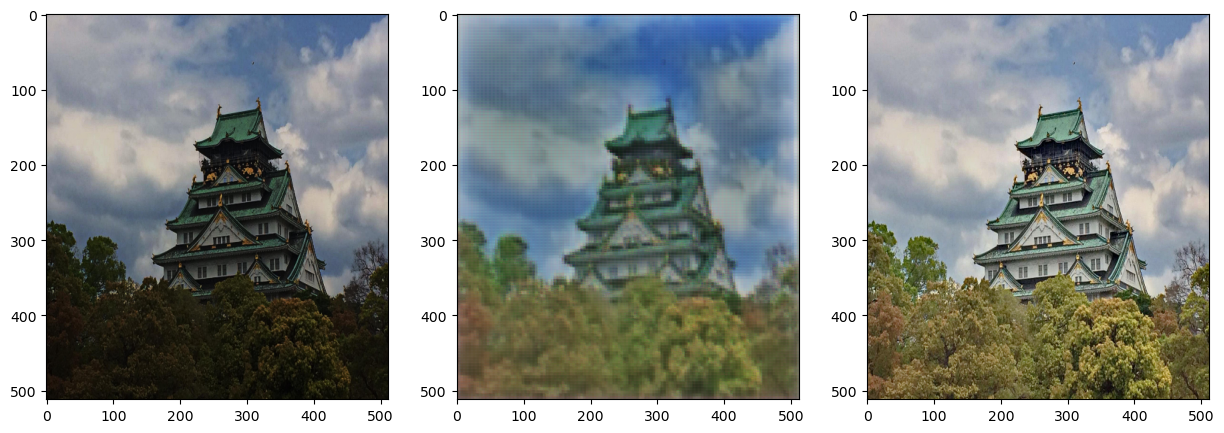

In [25]:
f, ax= plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(test_samples[2], aspect="auto")
ax[1].imshow(gen_imgs[2], aspect="auto")
ax[2].imshow(test_gts[2], aspect="auto")
plt.show()

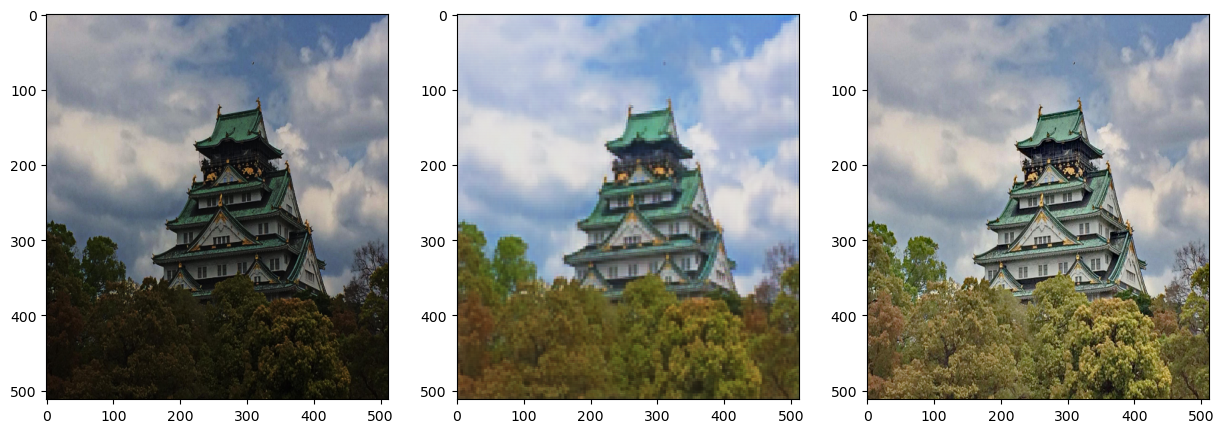

In [72]:
f, ax= plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(test_samples[2], aspect="auto")
ax[1].imshow(gen_imgs[2], aspect="auto")
ax[2].imshow(test_gts[2], aspect="auto")
plt.show()

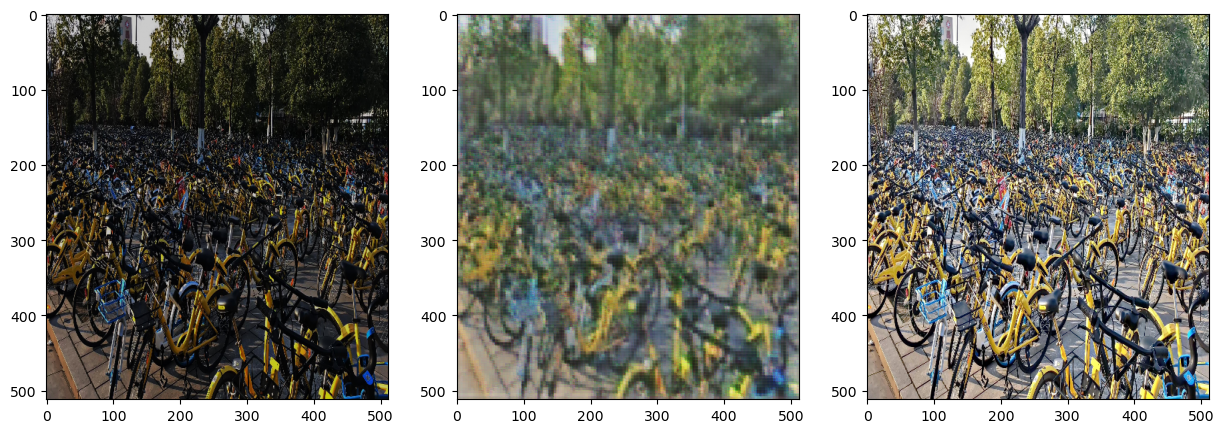

In [24]:
f, ax= plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(test_samples[3], aspect="auto")
ax[1].imshow(gen_imgs[3], aspect="auto")
ax[2].imshow(test_gts[3], aspect="auto")
plt.show()

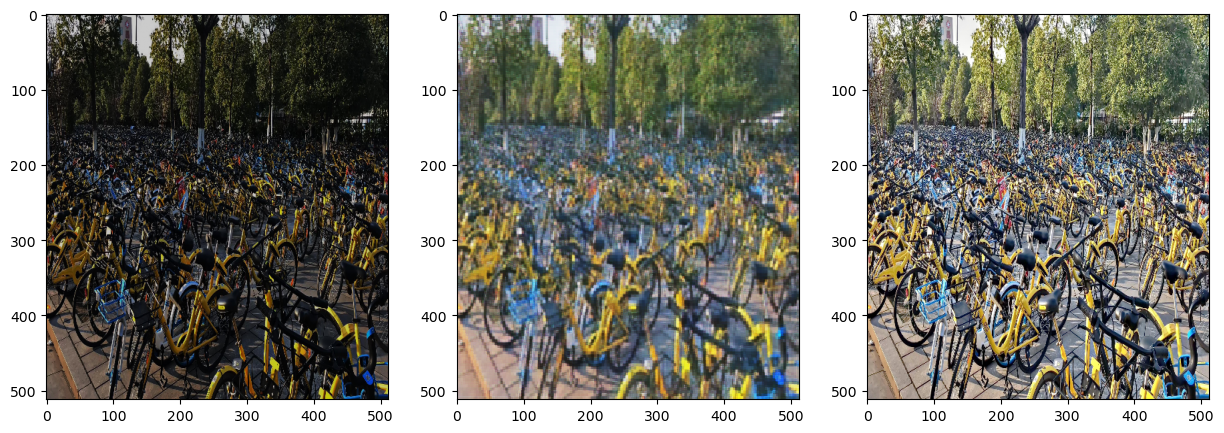

In [73]:
f, ax= plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(test_samples[3], aspect="auto")
ax[1].imshow(gen_imgs[3], aspect="auto")
ax[2].imshow(test_gts[3], aspect="auto")
plt.show()